In [1]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 113.5 MB/s eta 0:00:00


In [42]:
import cv2
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from time import time

In [41]:
torch.manual_seed(0)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [44]:
path = '/content/'

In [45]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [46]:
trainset = datasets.MNIST(path, download=True, train=True, transform=transform)
testset = datasets.MNIST(path, download=True, train=False, transform=transform)

In [47]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In this implementation, it was decided to increase the number of filters in the convolutional layer compared to the lesson example. This is done to allow for more complex and diverse features to be extracted from the input data.

In [158]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x2 = F.relu(self.conv2(x))
        # x = x + x2
        x = self.pool(x2)
        x = x.view(-1, 32* 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [51]:
convnet = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(convnet.parameters(), lr=0.03, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        res = convnet(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =",(time()-time0)/60)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = convnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 1.252
[1,   200] loss: 0.208
[1,   300] loss: 0.162
[1,   400] loss: 0.115
[1,   500] loss: 0.108
[1,   600] loss: 0.096
[1,   700] loss: 0.080
[1,   800] loss: 0.087
[1,   900] loss: 0.087

Training Time (in minutes) = 0.2247780442237854
Accuracy: 98 %


In [52]:
import onnx

In [56]:
x = torch.randn(64, 1, 28,28).to(device)
torch.onnx.export(convnet, x, path+'models/convnet.onnx')

In [57]:
model=cv2.dnn.readNetFromONNX(path+'models/convnet.onnx')

In [58]:
from matplotlib import pyplot as plt

In [59]:
image = cv2.imread(path+'assets/0-9.png')

In [60]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img.shape[:2]

In [61]:
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255,255,0),1)
    sz2 = int(1.1*max(w,h)/2)
    xc = x + int(w/2)
    yc = y + int(h/2)
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255,0,0),1)
    img2 = img[max(0,yc-sz2):min(yc+sz2,height-1),max(0,xc-sz2):min(width-1,xc+sz2)]
    img2 = cv2.resize(img2, (28, 28))
    blob = cv2.dnn.blobFromImage(img2, 1./127, (28,28), (127,127,127), True)
    model.setInput(blob)
    outs = model.forward()
    res = np.argmax(outs)

    cv2.putText(image, str(res), (x-10, y+10),  cv2.FONT_HERSHEY_SIMPLEX,
	1.5, (50, 50, 255),1)

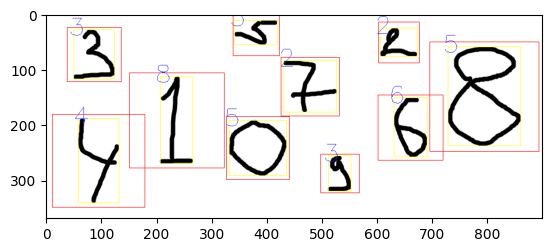

In [62]:
plt.imshow(image, cmap="gray")

### Depthwise Separable convolutions

A depthwise-separable convolution is the combination of both depthwise followed by a pointwise convolutions.
* Depthwise Convolution is a type of convolution where we apply a single convolutional filter for each input channel
* Pointwise Convolution is a type of convolution that uses a 1x1 kernel


In [63]:
import torch.nn as nn
import torch.nn.functional as F

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5,
                  stride=1, padding=0,  dilation=1, bias=True):
        super(DepthwiseSeparableConv, self).__init__()

        self.depthwise = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                   kernel_size=kernel_size, stride=stride,
                                   padding=padding,  dilation=dilation,
                                   groups=in_channels, bias=bias
                                   )

        self.pointwise = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                   kernel_size=1,  #pointwise convolution
                                   stride=1, padding=0,
                                   dilation=1, groups=1, bias=bias
                                   )
    def forward(self, x):
        x = self.depthwise(x)
        # print(f"After Depthwise:{x.shape}")
        x = self.pointwise(x)
        # print(f"After Pointwise:{x.shape}")
        return x

In [69]:
class DeptConvNet(nn.Module):
    def __init__(self):
        super(DeptConvNet, self).__init__()
        self.conv1 = DepthwiseSeparableConv(in_channels=1, out_channels=16,
                                             kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = DepthwiseSeparableConv(in_channels=16, out_channels=32,
                                            kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [71]:
deptconvnet = DeptConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(deptconvnet.parameters(), lr=0.03, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        res = deptconvnet(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =",(time()-time0)/60)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = deptconvnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 2.055
[1,   200] loss: 0.506
[1,   300] loss: 0.264
[1,   400] loss: 0.220
[1,   500] loss: 0.191
[1,   600] loss: 0.157
[1,   700] loss: 0.138
[1,   800] loss: 0.146
[1,   900] loss: 0.136

Training Time (in minutes) = 0.22829102675120036
Accuracy: 97 %


| Conv Type | Time (min) |Accuracy  |
|  :---: |  :---: |  :---: |
| Vanilla Convolusion | 0.2248 | 98% |
| Depthwise Separable | 0.2283 | 97% |

The computational speed for one epoch is nearly identical between the two convolution types. This is unexpected, as Depthwise Separable convolutions are generally expected to be faster than Vanilla Convolutions.

### Data Augmentation

The transformation composition applied to the training images includs random rotations up to 10 degrees, random adjustments to brightness, contrast, saturation, and hue using ColorJitter.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [106]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [107]:
trainset = datasets.MNIST(path, download=True, train=True, transform=transform_train)
testset = datasets.MNIST(path, download=True, train=False, transform=transform_test)

In [108]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [109]:
convnet = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(convnet.parameters(), lr=0.03, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        res = convnet(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =",(time()-time0)/60)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = convnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 1.339
[1,   200] loss: 0.247
[1,   300] loss: 0.153
[1,   400] loss: 0.158
[1,   500] loss: 0.133
[1,   600] loss: 0.105
[1,   700] loss: 0.093
[1,   800] loss: 0.090
[1,   900] loss: 0.094

Training Time (in minutes) = 0.6058696587880452
Accuracy: 98 %


In [113]:
deptconvnet =  DeptConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(deptconvnet.parameters(), lr=0.03, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        res = deptconvnet(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =",(time()-time0)/60)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = deptconvnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 2.294
[1,   200] loss: 1.079
[1,   300] loss: 0.451
[1,   400] loss: 0.314
[1,   500] loss: 0.275
[1,   600] loss: 0.226
[1,   700] loss: 0.205
[1,   800] loss: 0.178
[1,   900] loss: 0.156

Training Time (in minutes) = 0.5678592642148336
Accuracy: 96 %


**Before Data Augmentation**

| Conv Type | Time (min) |Accuracy  |
|  :---: |  :---: |  :---: |
| Vanilla Convolusion | 0.2248 | 98% |
| Depthwise Separable | 0.2283 | 97% |

**After Data Augmentation**

| Conv Type | Time (min) |Accuracy  |
|  :---: |  :---: |  :---: |
| Vanilla Convolusion | 0.6058 | 98% |
| Depthwise Separable | 0.5678 | 96% |

The accuracy of Vanilla Convolution remains very high and stable (98%)  and data augmentation does not effect that much. Accuracy with Depthwise Separable slightly decreased (96%) and maybe this type of convolution is more sensitive to data changes introduced by augmentation and it needs more epochs to adapt to these changes.

Moreover, in this example we can see that Depthwise Separable Convolution is faster than Vanilla one.
